In [1]:
import mnist_loader
import network
import numpy as np
from matplotlib import pyplot as plt

In [2]:
training_data, validation_data, test_data,train_ae,val_ae,test_ae = mnist_loader.load_data_wrapper(make_binary =True)

In [3]:
net = network.Network([784, 30, 10], cost=network.CrossEntropyCost,doSmallWorld=True)
net.large_weight_initializer()
net.SGD(training_data, 5, 10, 0.5)

Epoch 0 training complete

Epoch 1 training complete

Epoch 2 training complete

Epoch 3 training complete

Epoch 4 training complete



([], [], [], [])

In [7]:
test_in = np.transpose([np.squeeze(i[0]) for i in test_data])
posteriors = net.feedforward(test_in)
test_pred = np.argmax(posteriors,0)
np.shape(test_in)

(784, 10000)

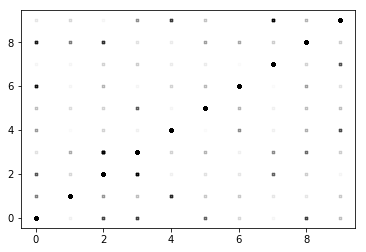

In [8]:
test_out = [i[1] for i in test_data]
plt.plot(test_out,test_pred,'k.',alpha=.01)
plt.show()

# Try autoendoder Network

In [6]:
reload(network)

net_ae = network.Network([784,30,10,30,784], cost=network.QuadraticCost,doHeavy = False,doSmallWorld=True,add_rand=10)
net_ae.large_weight_initializer()
net_ae.SGD(train_ae, 5, 5, 0.5,evaluation_data=val_ae) # 10, 10, 0.5

Epoch 0 training complete

Epoch 1 training complete

Epoch 2 training complete

Epoch 3 training complete

Epoch 4 training complete



([], [], [], [])

In [23]:
reload(network)
net_ae_we = network.Network([784,30,10,30,784], cost=network.QuadraticCost_withEnergy,doHeavy = False,doSmallWorld=True,add_rand=10)
net_ae_we.large_weight_initializer()
net_ae_we.SGD(train_ae, 5, 5, 0.5,evaluation_data=val_ae) # 10, 10, 0.5

Epoch 0 training complete

Epoch 1 training complete

Epoch 2 training complete

Epoch 3 training complete

Epoch 4 training complete



([], [], [], [])

('Entropy:', 9.5656410361466868)
('Acc Reconstructed:', 0.6008, 'Acc OG:', 8244)


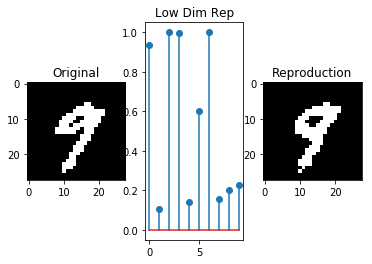

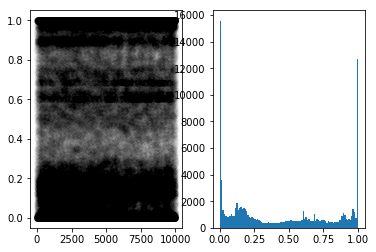

In [27]:
def quick_eval(net_in,VERBOSE = False):
    #in_dat  = test_ae[3211][0]
    #out_dat = net_in.feedforward(in_dat)
    wts = net_in.weights
    bias = net_in.biases

    decoder_wts = wts[2:]
    decoder_bias = bias[2:]
    encoder_wts = wts[0:2]
    encoder_bias = bias[0:2]

    bottle_val,img_out = encode_decode(wts,bias,test_ae[:10000])

    bottle_val_bool = (bottle_val>.5)*1
    avg_val = np.mean(bottle_val_bool,0)
    print('Entropy:',np.sum(bin_ent(avg_val)))

    # classify outputs using old network
    img_out_b = (img_out>.5)*1
    img_out_bt = np.transpose((img_out>.5)*1)
    posteriors = net.feedforward(img_out_bt)
    pred = np.argmax(posteriors,0)
    acc = np.mean(pred==test_out)
    acc_og = net.accuracy(test_data)
    print('Acc Reconstructed:',acc,'Acc OG:',acc_og)
    
    if VERBOSE:
        # plot images
        in_dat  = test_ae[20][0] # 45
        cent = use_decode(encoder_wts,encoder_bias,in_dat)
        in_probe = cent
        tmp_out = use_decode(decoder_wts,decoder_bias,in_probe)
        tmp2 = tmp_out
        tmp2 = (tmp2>.5)*1
        np.shape(tmp2)

        plt.subplot(1,3,1)
        plt.imshow(np.reshape(in_dat,(28,28)),cmap='gray')
        plt.title('Original')
        plt.subplot(1,3,2)
        plt.stem(cent)
        plt.title('Low Dim Rep')
        plt.subplot(1,3,3)
        plt.imshow(np.reshape(tmp2,(28,28)),cmap='gray')
        plt.title('Reproduction')
        plt.show()

        # plot middle layer
        plt.subplot(1,2,1)
        plt.plot(b_val,'ko',alpha=.01)
        plt.subplot(1,2,2)
        f_val = b_val.flatten()
        plt.hist(f_val,100)
        plt.show()

('Entropy:', 9.5656410361466868)
('Acc Reconstructed:', 0.6008, 'Acc OG:', 8244)


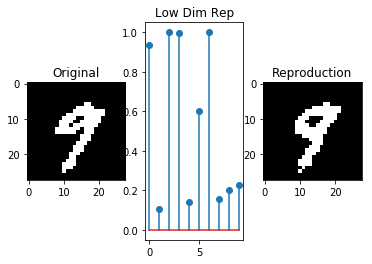

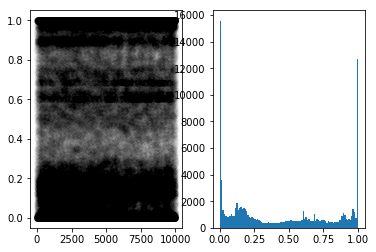

('Entropy:', 9.4513098252986723)
('Acc Reconstructed:', 0.49330000000000002, 'Acc OG:', 8244)


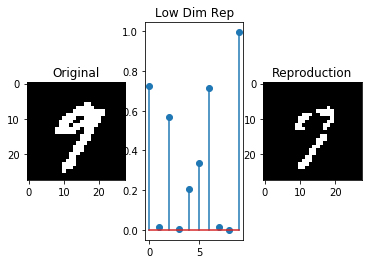

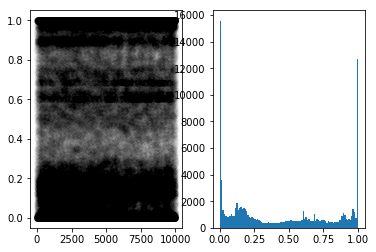

In [28]:
quick_eval(net_ae,True)    
quick_eval(net_ae_we,True)   

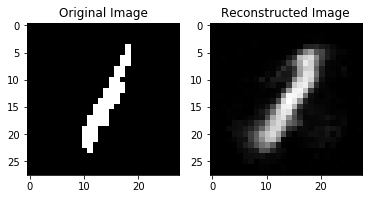

In [24]:
# TO DO
# Add Noise
# measure stats in function
#  -acc
#  -entropy
# Add energy use penalty

in_dat  = test_ae[3211][0]
out_dat = net_ae.feedforward(in_dat)
wts = net_ae.weights
bias = net_ae.biases

decoder_wts = wts[2:]
decoder_bias = bias[2:]
encoder_wts = wts[0:2]
encoder_bias = bias[0:2]

plt.subplot(1,2,1)
plt.imshow(np.reshape(in_dat,(28,28)),cmap='gray')
plt.title('Original Image')
plt.subplot(1,2,2)
plt.imshow(np.reshape(out_dat,(28,28)),cmap='gray')
plt.title('Reconstructed Image')
plt.show()

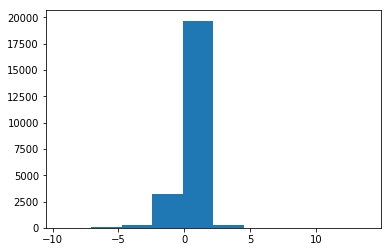

(10000, 2, 784, 1)

In [25]:
grp = 0
plt.hist(wts[grp][np.isnan(wts[grp])==0].flatten())
plt.show()
np.shape(test_ae)

In [16]:
def use_decode(wts,bias,a):
    for b, w in zip(bias, wts):
        a = sigmoid(np.dot(w, a)+b)
    return a

def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def heavyside_99(z):
    """Heavyside Function w/o hitting edge"""
    return (z>0)*.99+((z>0)==0)*.01

def encode_decode(wts,bias,in_val):
    try:
        n_bottleneck = len(wts[2][1]) # assuming 5 layer NN
        do_tran = False
    except:  
        n_bottleneck = len(wts[2]) # correction for data type
        do_tran = True 
    n_layer = len(wts)
    n_trials = len(in_val)
    n_dim = np.shape(test_ae)[2]
    bot_val = np.zeros((n_trials,n_bottleneck))
    img_out = np.zeros((n_trials,n_dim))
    
    if do_tran:
        wts = [np.transpose(x) for x in wts]
        bias = [np.transpose(x) for x in bias]
    
    for i in range(len(in_val)):
        a = in_val[i][0]
        for ii in range(n_layer):
            a = sigmoid(np.dot(wts[ii],a)+bias[ii])
            if ii == 1:
                bot_val[i,:] = np.squeeze(a)
            if ii == n_layer-1:
                img_out[i,:] = np.squeeze(a)
    return bot_val, img_out
def bin_ent(p): 
    ent = -(p*np.log2(p)+(1-p)*np.log2(1-p))
    ent[np.isnan(ent)]=0
    return ent
                

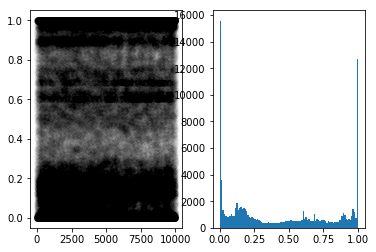

In [14]:
b_val,img_out = encode_decode(wts,bias,test_ae[:10000])
plt.subplot(1,2,1)
plt.plot(b_val,'ko',alpha=.01)
plt.subplot(1,2,2)
f_val = b_val.flatten()
plt.hist(f_val,100)
plt.show()

In [18]:
# bool central layer, then compute entropy
b_val_bool = (b_val>.5)*1
avg_val = np.mean(b_val_bool,0)
print('Entropy:',np.sum(bin_ent(avg_val)))

('Entropy:', 9.5656410361466868)


In [863]:
foo = dat_eval_net[0][0]
bar = dat_eval_net[0][1]
np.shape(img_out)

(10000, 784)

In [22]:
# check accuracy of output
np.shape(img_out)
img_out_b = (img_out>.5)*1
img_out_bt = np.transpose((img_out>.5)*1)

posteriors = net.feedforward(img_out_bt)
pred = np.argmax(posteriors,0)
acc = np.mean(pred==test_out)
plt.title('Reconstructed Image')

acc_og = net.accuracy(test_data)
print('Acc Reconstructed:',acc,'Acc OG:',acc_og)

('Acc Reconstructed:', 0.6008, 'Acc OG:', 8244)


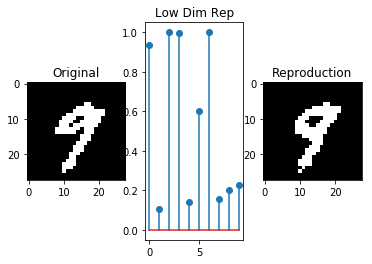

In [21]:
# in_probe = np.array([0, 0,0, 0, 0])
in_dat  = test_ae[20][0] # 45
cent = use_decode(encoder_wts,encoder_bias,in_dat)
in_probe = cent
tmp_out = use_decode(decoder_wts,decoder_bias,in_probe)
tmp2 = tmp_out
tmp2 = (tmp2>.5)*1
np.shape(tmp2)

plt.subplot(1,3,1)
plt.imshow(np.reshape(in_dat,(28,28)),cmap='gray')
plt.title('Original')
plt.subplot(1,3,2)
plt.stem(cent)
plt.title('Low Dim Rep')
plt.subplot(1,3,3)
plt.imshow(np.reshape(tmp2,(28,28)),cmap='gray')
plt.title('Reproduction')
plt.show()

# compute entropy

/home/AD/tsheehan/anaconda3/envs/mne/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log2
  
/home/AD/tsheehan/anaconda3/envs/mne/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


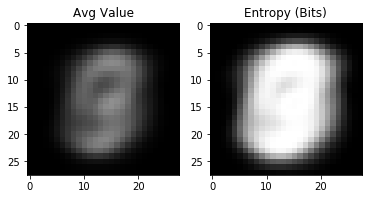

In [451]:
# now that it is binary simply compute 
foo = training_data
x = [i[0] for i in training_data]
x_avg = np.mean(x,0)
x_ent = bin_ent(x_avg)
plt.subplot(1,2,1)
plt.imshow(np.reshape(x_avg,(28,28)),vmin=0, vmax=1,cmap='gray')
plt.title('Avg Value')
plt.subplot(1,2,2)
plt.imshow(np.reshape(x_ent,(28,28)),vmin=0, vmax=1,cmap='gray')
plt.title('Entropy (Bits)')
plt.show()

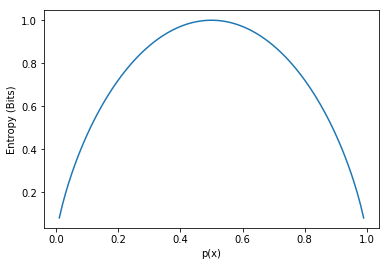

In [175]:

x = np.arange(0.01,1,.01)
plt.plot(x,bin_ent(x))
plt.xlabel('p(x)')
plt.ylabel('Entropy (Bits)')
plt.show()

In [93]:
foo = list(map(lambda x:(x>.5)*1,t_in))

In [854]:
net_size = [28*28,30,5,30,28*28]
plt.title('Reconstructed Image')
import random
from scipy.spatial.distance import cdist 
#for n in range(len(net_size)-1):
n = 0

rad1 = (np.arange(net_size[n],dtype=float)/net_size[n])*2*np.pi
rad2 = (np.arange(net_size[n+1],dtype=float)/net_size[n+1])*2*np.pi

def xy_dist_rad(rad1,rad2):
 
    return mat
def gen_weights_local(nx,ny,tol,add_rand=None):
    rad1 = (np.arange(nx,dtype=float)/nx)*2*np.pi
    rad2 = (np.arange(ny,dtype=float)/ny)*2*np.pi
    loc1 = np.transpose(np.array([np.cos(rad1),np.sin(rad1)]))
    loc2 = np.transpose(np.array([np.cos(rad2),np.sin(rad2)]))
    mat = cdist(loc2,loc1)
    in_thresh = mat<tol
    norm = np.mean(in_thresh)*np.sqrt(nx)
    if add_rand:
        long_cnx = add_rand_con(nx,ny,add_rand)
        in_thresh[long_cnx] = 1
    wts = np.random.randn(ny, nx)/norm
    wts[in_thresh==0] = 0
    return wts
def add_rand_con(nx,ny,pct):
    #nx,ny,pct = 20,5,10
    pool = np.arange(nx*ny)
    cnx = np.array(random.sample(pool,nx*ny*pct/100))
    p_x = cnx%nx
    p_y = cnx//nx
    new_wts = np.zeros((ny,nx))==1
    new_wts[p_y,p_x] = True
    return new_wts

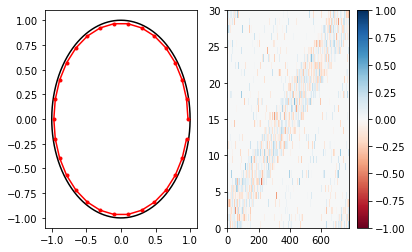

In [855]:
tol = .8
wts = gen_weights_local(net_size[0],net_size[1],tol,add_rand = 10)

plt.subplot(1,2,1)
plt.plot(np.cos(this_layer),np.sin(this_layer),'k',markersize=1)
plt.plot(np.cos(next_layer)*.97,np.sin(next_layer)*.97,'r.-')
plt.subplot(1,2,2)
plt.pcolormesh(wts,cmap='RdBu',vmin=-1,vmax=1)
plt.colorbar()
plt.show()


In [652]:
foo = np.array([5, 3, 1, 14],dtype=float)
foo[foo<4] = np.nan
np.isnan(foo)

array([False,  True,  True, False], dtype=bool)

In [711]:
foo = np.array([[4, 2, 1],[3,0,2]])
foo[0]

array([4, 2, 1])

In [713]:
help(random.sample)

Help on method sample in module random:

sample(self, population, k) method of random.Random instance
    Chooses k unique random elements from a population sequence.
    
    Returns a new list containing elements from the population while
    leaving the original population unchanged.  The resulting list is
    in selection order so that all sub-slices will also be valid random
    samples.  This allows raffle winners (the sample) to be partitioned
    into grand prize and second place winners (the subslices).
    
    Members of the population need not be hashable or unique.  If the
    population contains repeats, then each occurrence is a possible
    selection in the sample.
    
    To choose a sample in a range of integers, use xrange as an argument.
    This is especially fast and space efficient for sampling from a
    large population:   sample(xrange(10000000), 60)

